# pki_models.ipynb

The purpose of this file is to fix the class imbalance problem that exists in the pki dataset. To address this issue, we will apply the following methods:
1. Upsampling
2. Downsampling

Then, we will create a logistic regression, support vector machine, and decision tree model based on the resampled data.

For the logistic regression model, we will assume that the optimal max_iter value is 500 and the optimal regularization parameter is 10 (found in MLP3).

For the SVM model, we will assume that the optimal C value is 100 (found in MLP3).

For the decision tree model, we will assume that the optimal depth is 10 (found in MLP3).

## Authors
1. Riley Cullen
2. Mason Adsero

## Data

In [85]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

pki_df = pd.read_csv("../MLP2/input/heart_2020_normalized.csv")
x_columns = ['BMI', 'Smoking', 'AlcoholDrinking', 'Stroke', \
    'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory', \
    'PhysicalActivity', 'GenHealth', 'SleepTime', 'Asthma', 'KidneyDisease', \
    'SkinCancer', 'American Indian/Alaskan Native', 'Asian', 'Black', \
    'Hispanic', 'Other', 'White', 'No diabetes', 'Borderline diabetes', \
    'Has diabetes', 'Has diabetes (during pregnancy)', 'No diabetes']
y_columns = ['HeartDisease']
target_names = ['No Heart Disease', 'Has Heart Disease']

## Resampling the dataset

In [86]:
from sklearn.utils import resample

positive_df = pki_df[pki_df['HeartDisease'] == 1]
negative_df = pki_df[pki_df['HeartDisease'] == 0]

print("Postive instances shape: ", positive_df.shape)
print("Negative instances shape: ", negative_df.shape)

Postive instances shape:  (27373, 26)
Negative instances shape:  (292422, 26)


### Downsampling the data

d_X shape:  (54746, 26)
d_y shape:  (54746, 1)

X_train shape:  (38322, 26)
X_test shape:  (16424, 26)
y_train shape:  (38322, 1)
y_test shape:  (16424, 1)


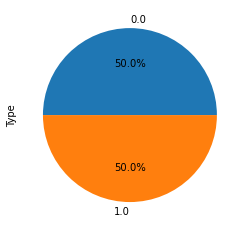

In [87]:
downsample = resample(negative_df, replace=True, n_samples=len(positive_df), random_state=42)
downsampled_df = pd.concat([downsample, positive_df])
downsampled_df.groupby('HeartDisease').size().plot(kind='pie', y='HeartDisease', label='Type', autopct='%1.1f%%')

d_X = np.c_[downsampled_df[x_columns]]
d_y = np.c_[downsampled_df[y_columns]]

print("d_X shape: ", d_X.shape)
print("d_y shape: ", d_y.shape)

dX_train, dX_test, dy_train, dy_test = train_test_split(d_X, d_y, test_size=0.3, random_state=42)
print("\nX_train shape: ", dX_train.shape)
print("X_test shape: ", dX_test.shape)
print("y_train shape: ", dy_train.shape)
print("y_test shape: ", dy_test.shape)

### Upsampling the data
Because of the size of the negative instances, we will first cut the dataframe in half then upsample the positive instances.

d_X shape:  (292422, 26)
d_y shape:  (292422, 1)

X_train shape:  (204695, 26)
X_test shape:  (87727, 26)
y_train shape:  (204695, 1)
y_test shape:  (87727, 1)


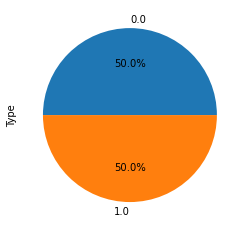

In [88]:
tmp = resample(negative_df, replace=True, n_samples=int(len(negative_df) / 2), random_state=42)
upsample = resample(positive_df, replace=True, n_samples=len(tmp), random_state=42)
upsampled_df = pd.concat([tmp, upsample])
upsampled_df.groupby('HeartDisease').size().plot(kind='pie', y='HeartDisease', label='Type', autopct='%1.1f%%')

u_X = np.c_[upsampled_df[x_columns]]
u_y = np.c_[upsampled_df[y_columns]]

print("d_X shape: ", u_X.shape)
print("d_y shape: ", u_y.shape)

uX_train, uX_test, uy_train, uy_test = train_test_split(u_X, u_y, test_size=0.3, random_state=42)
print("\nX_train shape: ", uX_train.shape)
print("X_test shape: ", uX_test.shape)
print("y_train shape: ", uy_train.shape)
print("y_test shape: ", uy_test.shape)

### Training on the downsampled data

In [89]:
# Logistic Regression
lr_max_iter = 500
lr_c = 10

log_reg_d = LogisticRegression(max_iter=lr_max_iter, C=lr_c, ).fit(dX_train, dy_train.ravel())

### Evaluation on downsampled data

#### Logisitic Regression Model

In [90]:
y_pred = log_reg_d.predict(dX_test)
confusion_mat = confusion_matrix(dy_test, y_pred, labels=[1, 0])
print(confusion_mat, "\n\n")

print(classification_report(dy_test, y_pred, target_names=target_names))

class_report = classification_report(dy_test, y_pred, target_names=target_names, output_dict=True)

class_df = pd.DataFrame(class_report).transpose()
class_df.to_csv('./results/d_logreg_classification_report_test.csv')

[[6366 1863]
 [2105 6090]] 


                   precision    recall  f1-score   support

 No Heart Disease       0.77      0.74      0.75      8195
Has Heart Disease       0.75      0.77      0.76      8229

         accuracy                           0.76     16424
        macro avg       0.76      0.76      0.76     16424
     weighted avg       0.76      0.76      0.76     16424



Accuracy =  0.836984626535821


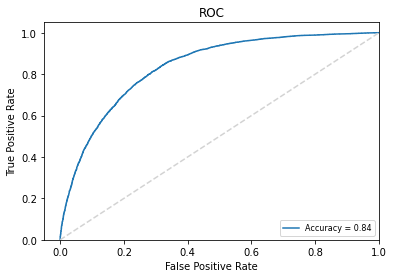

In [91]:
y_score = log_reg_d.predict_proba(dX_test)

false_positive_rate, true_positive_rate, thresholds = roc_curve(dy_test, y_score[:,1])

roc_auc = auc(false_positive_rate, true_positive_rate)

print('Accuracy = ', roc_auc)

# Plotting
plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate, label=('Accuracy = %0.2f'%roc_auc))
plt.legend(loc='lower right', prop={'size':8})
plt.plot([0,1],[0,1], color='lightgrey', linestyle='--')
plt.xlim([-0.05,1.0])
plt.ylim([0.0,1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("./results/d_logreg_roc_test.png", bbox_inches='tight', transparent=False, facecolor='white')
plt.show()

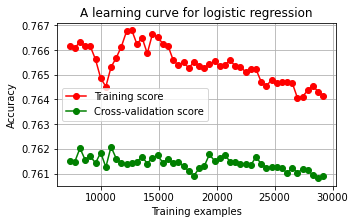

In [92]:
train_sizes = np.linspace(0.2, 0.8, 50)

train_sizes, train_mse, test_mse = learning_curve(log_reg_d, d_X, d_y.ravel(), 
                                    train_sizes = train_sizes, 
                                    scoring='accuracy', 
                                    cv=3, shuffle=True)

train_scores = train_mse
test_scores = test_mse

#print(train_scores)
#print(test_scores)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot learning curve
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    
ax.set_title('A learning curve for logistic regression')
ax.set_xlabel("Training examples")
ax.set_ylabel("Accuracy")
ax.grid()

ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
ax.legend(loc="best")

plt.savefig("./results/d_logreg_learning_curve.png", bbox_inches='tight', transparent=False, facecolor='white')
plt.show()

#### SVM Model

In [93]:
svm_C = 100

svm_d = LinearSVC(C=svm_C).fit(dX_train, dy_train.ravel())

/Users/rileycullen/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [94]:
y_pred = svm_d.predict(dX_test)
confusion_mat = confusion_matrix(dy_test, y_pred, labels=[1, 0])
print(confusion_mat, "\n\n")

print(classification_report(dy_test, y_pred, target_names=target_names))

class_report = classification_report(dy_test, y_pred, target_names=target_names, output_dict=True)

class_df = pd.DataFrame(class_report).transpose()
class_df.to_csv('./results/d_svm_classification_report_test.csv')

[[7842  387]
 [4954 3241]] 


                   precision    recall  f1-score   support

 No Heart Disease       0.89      0.40      0.55      8195
Has Heart Disease       0.61      0.95      0.75      8229

         accuracy                           0.67     16424
        macro avg       0.75      0.67      0.65     16424
     weighted avg       0.75      0.67      0.65     16424



Accuracy =  0.8247507753757952


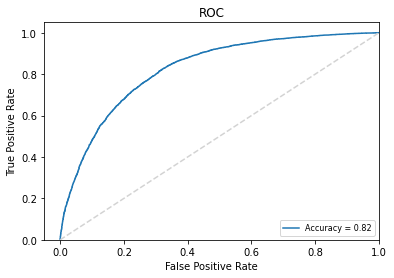

In [95]:
y_score = svm_d.decision_function(dX_test)

false_positive_rate, true_positive_rate, thresholds = roc_curve(dy_test, y_score)

roc_auc = auc(false_positive_rate, true_positive_rate)

print('Accuracy = ', roc_auc)

# Plotting
plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate, label=('Accuracy = %0.2f'%roc_auc))
plt.legend(loc='lower right', prop={'size':8})
plt.plot([0,1],[0,1], color='lightgrey', linestyle='--')
plt.xlim([-0.05,1.0])
plt.ylim([0.0,1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("./results/d_svm_roc_test.png", bbox_inches='tight', transparent=False, facecolor='white')
plt.show()

/Users/rileycullen/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/rileycullen/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/rileycullen/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/rileycullen/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/rileycullen/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.p

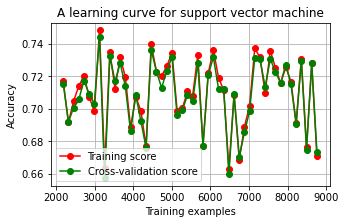

In [96]:
train_sizes = np.linspace(0.2, 0.8, 50)

train_sizes, train_mse, test_mse = learning_curve(svm_d, dX_test, dy_test.ravel(), 
                                    train_sizes = train_sizes, 
                                    scoring='accuracy', 
                                    cv=3, shuffle=True)

train_scores = train_mse
test_scores = test_mse

#print(train_scores)
#print(test_scores)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot learning curve
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    
ax.set_title('A learning curve for support vector machine')
ax.set_xlabel("Training examples")
ax.set_ylabel("Accuracy")
ax.grid()

ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
ax.legend(loc="best")

plt.savefig("./results/d_svm_learning_curve.png", bbox_inches='tight', transparent=False, facecolor='white')
plt.show()

#### Decision Tree Model

In [97]:
dt_depth = 10
dt_d = DecisionTreeClassifier(max_depth=dt_depth).fit(dX_train, dy_train)

In [98]:
y_pred = dt_d.predict(dX_test)
confusion_mat = confusion_matrix(dy_test, y_pred, labels=[1, 0])
print(confusion_mat, "\n\n")

print(classification_report(dy_test, y_pred, target_names=target_names))

class_report = classification_report(dy_test, y_pred, target_names=target_names, output_dict=True)

class_df = pd.DataFrame(class_report).transpose()
class_df.to_csv('./results/d_dt_classification_report_test.csv')

[[6265 1964]
 [2214 5981]] 


                   precision    recall  f1-score   support

 No Heart Disease       0.75      0.73      0.74      8195
Has Heart Disease       0.74      0.76      0.75      8229

         accuracy                           0.75     16424
        macro avg       0.75      0.75      0.75     16424
     weighted avg       0.75      0.75      0.75     16424



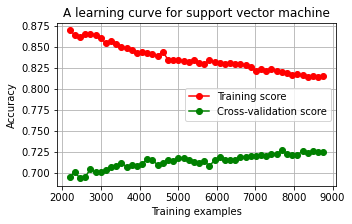

In [99]:
train_sizes = np.linspace(0.2, 0.8, 50)

train_sizes, train_mse, test_mse = learning_curve(dt_d, dX_test, dy_test.ravel(), 
                                    train_sizes = train_sizes, 
                                    scoring='accuracy', 
                                    cv=3, shuffle=True)

train_scores = train_mse
test_scores = test_mse

#print(train_scores)
#print(test_scores)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot learning curve
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    
ax.set_title('A learning curve for support vector machine')
ax.set_xlabel("Training examples")
ax.set_ylabel("Accuracy")
ax.grid()

ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
ax.legend(loc="best")

plt.savefig("./results/d_dt_learning_curve.png", bbox_inches='tight', transparent=False, facecolor='white')
plt.show()

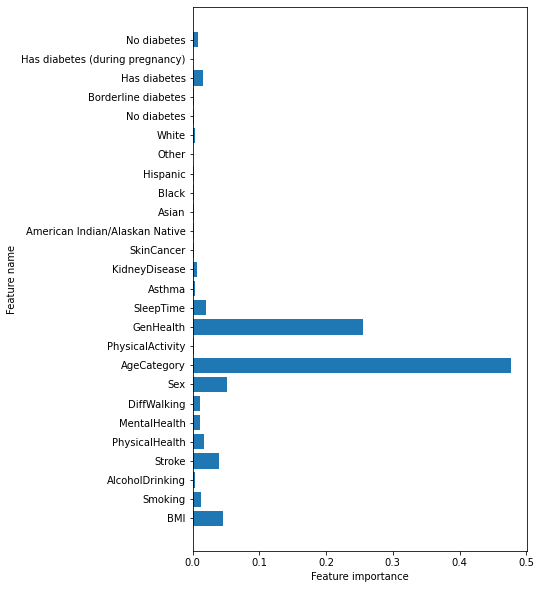

In [100]:
# plot important features
def plot_feature_importances(clf, feature_names):
    c_features = len(feature_names)
    plt.figure(figsize=(6, 10))
    plt.barh(range(c_features), clf.feature_importances_)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature name")
    plt.yticks(np.arange(c_features), feature_names, fontsize=10)

cols = ['BMI', 'Smoking', 'AlcoholDrinking', 'Stroke', \
    'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory', \
    'PhysicalActivity', 'GenHealth', 'SleepTime', 'Asthma', 'KidneyDisease', \
    'SkinCancer', 'American Indian/Alaskan Native', 'Asian', 'Black', \
    'Hispanic', 'Other', 'White', 'No diabetes', 'Borderline diabetes', \
    'Has diabetes', 'Has diabetes (during pregnancy)', 'No diabetes']

# call the function above
plot_feature_importances(dt_d, cols)
plt.savefig("./results/d_tree_important_features.png", bbox_inches='tight', transparent=False, facecolor='white')
plt.show()

### Upsampling the data

#### Logistic Regression Model

In [101]:
log_reg_u = LogisticRegression(max_iter=lr_max_iter, C=lr_c, ).fit(uX_train, uy_train.ravel())

In [102]:
y_pred = log_reg_u.predict(uX_test)
confusion_mat = confusion_matrix(uy_test, y_pred, labels=[1, 0])
print(confusion_mat, "\n\n")

print(classification_report(uy_test, y_pred, target_names=target_names))

class_report = classification_report(uy_test, y_pred, target_names=target_names, output_dict=True)

class_df = pd.DataFrame(class_report).transpose()
class_df.to_csv('./results/u_logreg_classification_report_test.csv')

[[34349  9685]
 [10917 32776]] 


                   precision    recall  f1-score   support

 No Heart Disease       0.77      0.75      0.76     43693
Has Heart Disease       0.76      0.78      0.77     44034

         accuracy                           0.77     87727
        macro avg       0.77      0.77      0.77     87727
     weighted avg       0.77      0.77      0.77     87727



Accuracy =  0.8423608858594371


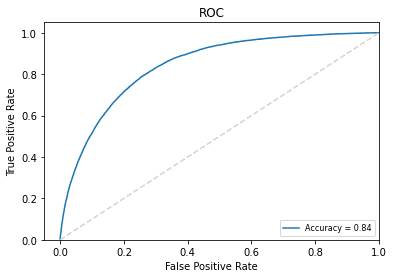

In [103]:
y_score = log_reg_u.predict_proba(uX_test)

false_positive_rate, true_positive_rate, thresholds = roc_curve(uy_test, y_score[:,1])

roc_auc = auc(false_positive_rate, true_positive_rate)

print('Accuracy = ', roc_auc)

# Plotting
plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate, label=('Accuracy = %0.2f'%roc_auc))
plt.legend(loc='lower right', prop={'size':8})
plt.plot([0,1],[0,1], color='lightgrey', linestyle='--')
plt.xlim([-0.05,1.0])
plt.ylim([0.0,1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("./results/u_logreg_roc_test.png", bbox_inches='tight', transparent=False, facecolor='white')
plt.show()

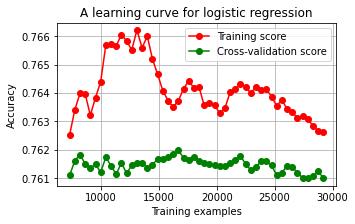

In [104]:
train_sizes = np.linspace(0.2, 0.8, 50)

train_sizes, train_mse, test_mse = learning_curve(log_reg_d, d_X, d_y.ravel(), 
                                    train_sizes = train_sizes, 
                                    scoring='accuracy', 
                                    cv=3, shuffle=True)

train_scores = train_mse
test_scores = test_mse

#print(train_scores)
#print(test_scores)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot learning curve
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    
ax.set_title('A learning curve for logistic regression')
ax.set_xlabel("Training examples")
ax.set_ylabel("Accuracy")
ax.grid()

ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
ax.legend(loc="best")

plt.savefig("./results/u_logreg_learning_curve.png", bbox_inches='tight', transparent=False, facecolor='white')
plt.show()

#### SVM Model

In [105]:
svm_u = LinearSVC(C=svm_C).fit(uX_train, uy_train.ravel())

/Users/rileycullen/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [106]:
y_pred = svm_u.predict(uX_test)
confusion_mat = confusion_matrix(uy_test, y_pred, labels=[1, 0])
print(confusion_mat, "\n\n")

print(classification_report(uy_test, y_pred, target_names=target_names))

class_report = classification_report(uy_test, y_pred, target_names=target_names, output_dict=True)

class_df = pd.DataFrame(class_report).transpose()
class_df.to_csv('./results/u_svm_classification_report_test.csv')

[[39905  4129]
 [22128 21565]] 


                   precision    recall  f1-score   support

 No Heart Disease       0.84      0.49      0.62     43693
Has Heart Disease       0.64      0.91      0.75     44034

         accuracy                           0.70     87727
        macro avg       0.74      0.70      0.69     87727
     weighted avg       0.74      0.70      0.69     87727



Accuracy =  0.8085175384701291


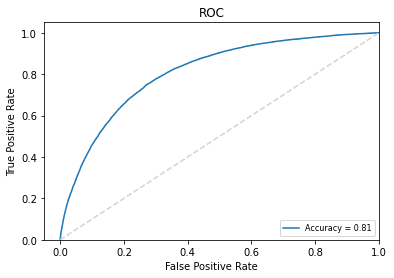

In [107]:
y_score = svm_u.decision_function(uX_test)

false_positive_rate, true_positive_rate, thresholds = roc_curve(uy_test, y_score)

roc_auc = auc(false_positive_rate, true_positive_rate)

print('Accuracy = ', roc_auc)

# Plotting
plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate, label=('Accuracy = %0.2f'%roc_auc))
plt.legend(loc='lower right', prop={'size':8})
plt.plot([0,1],[0,1], color='lightgrey', linestyle='--')
plt.xlim([-0.05,1.0])
plt.ylim([0.0,1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("./results/u_svm_roc_test.png", bbox_inches='tight', transparent=False, facecolor='white')
plt.show()

/Users/rileycullen/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/rileycullen/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/rileycullen/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/rileycullen/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/rileycullen/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.p

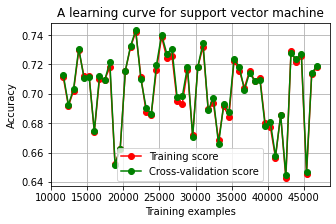

In [108]:
train_sizes = np.linspace(0.2, 0.8, 50)

train_sizes, train_mse, test_mse = learning_curve(svm_u, uX_test, uy_test.ravel(), 
                                    train_sizes = train_sizes, 
                                    scoring='accuracy', 
                                    cv=3, shuffle=True)

train_scores = train_mse
test_scores = test_mse

#print(train_scores)
#print(test_scores)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot learning curve
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    
ax.set_title('A learning curve for support vector machine')
ax.set_xlabel("Training examples")
ax.set_ylabel("Accuracy")
ax.grid()

ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
ax.legend(loc="best")

plt.savefig("./results/u_svm_learning_curve.png", bbox_inches='tight', transparent=False, facecolor='white')
plt.show()

#### Decision Tree Model

In [109]:
dt_u = DecisionTreeClassifier(max_depth=dt_depth).fit(uX_train, uy_train)

In [110]:
y_pred = dt_u.predict(uX_test)
confusion_mat = confusion_matrix(uy_test, y_pred, labels=[1, 0])
print(confusion_mat, "\n\n")

print(classification_report(uy_test, y_pred, target_names=target_names))

class_report = classification_report(uy_test, y_pred, target_names=target_names, output_dict=True)

class_df = pd.DataFrame(class_report).transpose()
class_df.to_csv('./results/u_dt_classification_report_test.csv')

[[36053  7981]
 [11911 31782]] 


                   precision    recall  f1-score   support

 No Heart Disease       0.80      0.73      0.76     43693
Has Heart Disease       0.75      0.82      0.78     44034

         accuracy                           0.77     87727
        macro avg       0.78      0.77      0.77     87727
     weighted avg       0.78      0.77      0.77     87727



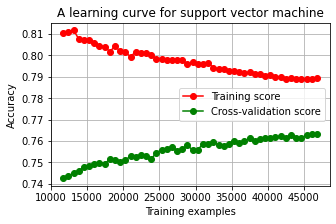

In [111]:
train_sizes = np.linspace(0.2, 0.8, 50)

train_sizes, train_mse, test_mse = learning_curve(dt_u, uX_test, uy_test.ravel(), 
                                    train_sizes = train_sizes, 
                                    scoring='accuracy', 
                                    cv=3, shuffle=True)

train_scores = train_mse
test_scores = test_mse

#print(train_scores)
#print(test_scores)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot learning curve
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    
ax.set_title('A learning curve for support vector machine')
ax.set_xlabel("Training examples")
ax.set_ylabel("Accuracy")
ax.grid()

ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
ax.legend(loc="best")

plt.savefig("./results/u_dt_learning_curve.png", bbox_inches='tight', transparent=False, facecolor='white')
plt.show()

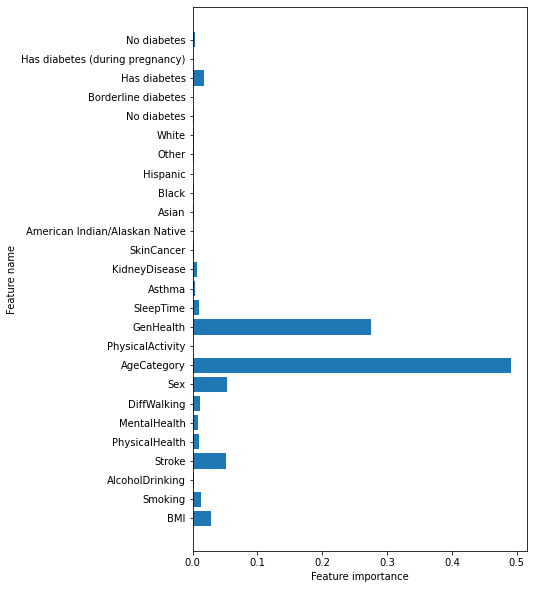

In [112]:
# plot important features
def plot_feature_importances(clf, feature_names):
    c_features = len(feature_names)
    plt.figure(figsize=(6, 10))
    plt.barh(range(c_features), clf.feature_importances_)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature name")
    plt.yticks(np.arange(c_features), feature_names, fontsize=10)

cols = ['BMI', 'Smoking', 'AlcoholDrinking', 'Stroke', \
    'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory', \
    'PhysicalActivity', 'GenHealth', 'SleepTime', 'Asthma', 'KidneyDisease', \
    'SkinCancer', 'American Indian/Alaskan Native', 'Asian', 'Black', \
    'Hispanic', 'Other', 'White', 'No diabetes', 'Borderline diabetes', \
    'Has diabetes', 'Has diabetes (during pregnancy)', 'No diabetes']

# call the function above
plot_feature_importances(dt_u, cols)
plt.savefig("./results/u_tree_important_features.png", bbox_inches='tight', transparent=False, facecolor='white')
plt.show()